In [3]:
# pad your sequences

from torch.nn.utils.rnn import pad_sequence
from pytorch_lightning.callbacks import LearningRateMonitor
import torch
import numpy as np
from PIL import Image
import os
from collections import defaultdict
import json
import joblib
from torch.utils.data import Dataset,DataLoader,random_split
from itertools import repeat
import pandas as pd
import math
import torch.nn as nn
import torch.nn.functional as F
from torch import linalg as LA
from argparse import Namespace
from numpy import genfromtxt
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau

import pytorch_lightning as pl
import wandb
import logging
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger, WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import clip



/common/home/vk405/miniconda3/envs/Crossmdl/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#utils

data_dir = '/common/users/vk405/Youcook/'
annotns_file ='/common/home/vk405/Projects/Crossmdl/Data/YouCookII/annotations/youcookii_annotations_trainval.json'
vid_data = [dir for dir in os.listdir(data_dir) if 'joblib' not in dir]

def get_vid_ids(split='training',\
    annotns_file='/common/home/vk405/Projects/Crossmdl/Data/YouCookII/annotations/youcookii_annotations_trainval.json'):
    # Returns vid_ids corresponding to the split: 'training'/'validation'
    
    vid_lis = []
    with open(annotns_file) as json_file:
        annotns = json.load(json_file)['database']
        for key in annotns:
            if annotns[key]['subset'] == split:
                vid_lis.append(key)
    return vid_lis




In [3]:
# len(vid_data)
# t = get_vid_ids()[0]
# t in set([dir for dir in os.listdir(data_dir) if 'joblib' not in dir])
# clipfeat_loc ='/common/users/vk405/CLIP_FEAT/'

In [3]:
def get_split_files(split='training',\
    annotns_file='/common/home/vk405/Projects/Crossmdl/Data/YouCookII/annotations/youcookii_annotations_trainval.json',\
        data_dir = '/common/users/vk405/Youcook/'):
    total_ids = get_vid_ids(split,annotns_file)
    downloaded_ids = set([dir for dir in os.listdir(data_dir) if 'joblib' not in dir])
    vid_locs = []
    sents = {}
    segs = {}
    incomplete = []
    for id in total_ids:
        if id in downloaded_ids:
            vid_loc = data_dir+id + '/'
            if len(os.listdir(vid_loc))>=495:
                vid_locs.append(vid_loc)
                seg = joblib.load(data_dir+f'{id}global_segs.joblib')
                sent = joblib.load(data_dir+f'{id}global_sents.joblib')
                try:
                    sents[id] = sent[id]
                    segs[id] = seg[id]
                except:
                    print(f"{id} is no corresponding global sent/seg")
            else:
                #print(f"{id} has only imgs {len(os.listdir(vid_loc))}")
                incomplete.append(id)
    return vid_locs,segs,sents,incomplete 




In [4]:
vid_locs,segs,sents,incomplete = get_split_files()
len(vid_locs)


1192

In [5]:
vid_locs,segs,sents,incomplete = get_split_files('validation')
len(vid_locs)

417

In [4]:
# base model

class YouClipDset(Dataset):
    #returns video-tensor,text-tensor,st_seg,end_seg -> these can be directly fed into CLIP
    def __init__(self,data_dir,annotns_file,split,\
        preproc_config = {'model':'clip','arch':'ViT-B/32'}):
        self.data_dir = data_dir
        self.annotns_file = annotns_file
        self.split = split
        self.preproc_config = preproc_config
        self.vid_locs,_,self.sents,_ = get_split_files(split,annotns_file,data_dir)
        self.data_pairs = self.get_pairs()
        if 'model' in preproc_config and preproc_config['model'] == 'clip':
            _, preprocess = clip.load(self.preproc_config['arch'])
            self.preprocess = preprocess
        self.incompletevids = set()
    def __len__(self):
        return len(self.data_pairs)


    def __getitem__(self,idx):
        if self.preproc_config['model'] == 'clip':
            vid_loc,sent,seg = self.data_pairs[idx]
            vid_imgs,txt_tokens = self.clip_preprocess(vid_loc,sent)
            return vid_imgs,txt_tokens,seg[0],seg[-1]

    def extract_seg(self,vid_loc,sz):
        imgs = sorted(os.listdir(vid_loc),key=lambda x: int(x.split('_')[0]))
        segs = defaultdict(list)
        for img in imgs:
            ind,rem = int(img.split('_')[0]),img.split('_')[-1]
            
            if 'n.' not in rem:
                #print(ind,rem)
                seg_id = int(rem.split('.')[0])
                segs[seg_id].append(ind)
                #print(seg_id,ind)
        final_segs = []
        #import pdb;pdb.set_trace()
        for i in range(1,sz+1):
            final_segs.append((min(segs[i]),max(segs[i])))

        return final_segs



    def get_pairs(self):
        pairs = []
        if self.preproc_config['model'] == 'clip':
            for vid_loc in self.vid_locs:
                vid_id = vid_loc.split('/')[-2]
                segs = self.extract_seg(vid_loc,len(self.sents[vid_id]))
                for sent,seg in zip(self.sents[vid_id],segs):
                    pairs.append((vid_loc,sent,seg))
        return pairs

    def clip_preprocess(self,vids_loc,txt):
        imgs = sorted(os.listdir(vids_loc),key=lambda x: int(x.split('_')[0]))
        proc_imgs = []
        #print(f"retrieved loc:{vids_loc}")
        for img in imgs:
            loc = vids_loc+img
            proc_img = self.preprocess(Image.open(loc))
            proc_imgs.append(proc_img)
        proc_txt = clip.tokenize(txt)
        return np.stack(proc_imgs),proc_txt





        


In [6]:
ydset = YouClipDset(data_dir,annotns_file,'training')
#ydset_val = YouClipDset(data_dir,annotns_file,'validation')

In [7]:
len(ydset)

9207

In [9]:
ydset.vid_locs[4]

'/common/users/vk405/Youcook/67ilysu8CeU/'

In [7]:
ydset_val = YouClipDset(data_dir,annotns_file,'validation')

In [8]:
len(ydset_val)

3033

In [8]:
clipfeat_loc ='/common/users/vk405/CLIP_FEAT/'

def extract_clip(split='training',
annotns_file='/common/home/vk405/Projects/Crossmdl/Data/YouCookII/annotations/youcookii_annotations_trainval.json',\
        data_dir = '/common/users/vk405/Youcook/',model_name = 'ViT-B/32',\
            store_dir = '/common/users/vk405/CLIP_FEAT/'):
    vid_locs,_,sents,_ = get_split_files(split,annotns_file,data_dir)
    useful_vids = []
    for vidloc in vid_locs:
        if len(os.listdir(vidloc)) != 500:
            files = sorted(os.listdir(vidloc),key=lambda x:int(x.split('_')[0]))
            if 'n.' in files[-1]:
                #if last image is not a segment, then we can safely add frames
                fileloc = vidloc + files[-1]
                filecnt = int(files[-1].split('_')[0])
                img = Image.open(fileloc)
                to_fill = 500-len(os.listdir(vidloc))
                for i in range(to_fill):
                    img.save(vidloc + f'{filecnt+i+1}_n.png')
                    print(f"saved at :{vidloc + f'{filecnt+i+1}_n.png'}")
                useful_vids.append(vidloc)
        else:
            useful_vids.append(vidloc)
    
    model,preprocess = clip.load(model_name)
    model.eval().cuda()
    error_cnt = {}
    for vidloc in useful_vids:
        vid_id = vidloc.split('/')[-2]
        save_loc_vid = store_dir+split+'/'+f'vid_{vid_id}.joblib'
        save_loc_text = store_dir+split+'/'+f'txt_{vid_id}.joblib'
        if not os.path.exists(save_loc_vid):
            text_tokens = clip.tokenize(sents[vid_id]).cuda()

            # with torch.no_grad():
            #     text_features = model.encode_text(text_tokens).float()
            #     joblib.dump(text_features.detach().cpu().numpy(),save_loc_text)
            files = sorted(os.listdir(vidloc),key=lambda x:int(x.split('_')[0]))
            if len(files) == 500:
                imgs  = []
                cnt = 0
                for file in files:
                    try:
                        im = Image.open(vidloc+file)
                        imgs.append(preprocess(im))
                    except:
                        # hoping here it wont be the first one
                        cnt += 1
                        imgs.append(imgs[-1])
                        #import pdb;pdb.set_trace()
                error_cnt[vid_id]  = cnt
                    
                image_input = torch.tensor(np.stack(imgs)).cuda()
                #import pdb;pdb.set_trace()
                im_emb = []
                with torch.no_grad():
                    # else can throw memory error
                    text_features = model.encode_text(text_tokens).float()
                    joblib.dump(text_features.detach().cpu().numpy(),save_loc_text)
                    out1 = model.encode_image(image_input[:250]).float()
                    out2 = model.encode_image(image_input[250:]).float()
                    im_emb = torch.concat([out1,out2],dim=0)
                    joblib.dump(im_emb.detach().cpu().numpy(),save_loc_vid)
                    print(error_cnt)
    return error_cnt
            
    

    
            
                
    



    
    

In [9]:
extract_clip()

{'GLd3aX16zBg': 1}


In [4]:
vid_feats = joblib.load('/common/users/vk405/CLIP_FEAT/training/vid_GLd3aX16zBg.joblib')

In [6]:
vid_feats[:3]

array([[-0.14978027, -0.26342773, -0.56591797, ...,  0.7729492 ,
        -0.36499023, -0.2932129 ],
       [ 0.02854919,  0.11401367, -0.04473877, ...,  0.7807617 ,
         0.19152832, -0.16699219],
       [-0.04202271,  0.1361084 , -0.10571289, ...,  0.89990234,
         0.2775879 , -0.26733398]], dtype=float32)

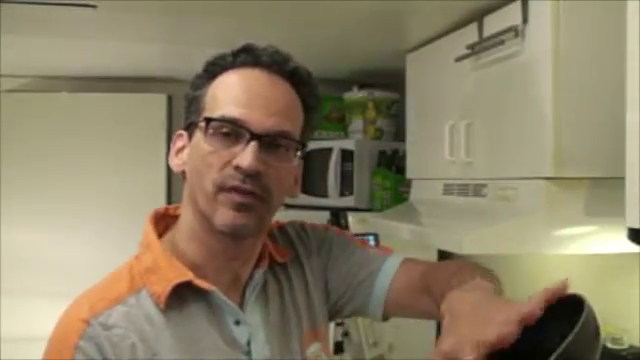

In [27]:
d = '/common/users/vk405/Youcook/GLd3aX16zBg/100_n.png'

Image.open(d)

In [11]:


model_name = 'ViT-B/32'
smaple_vids = ['/common/users/vk405/Youcook/H_9oM1Y60lU/','/common/users/vk405/Youcook/XOwypmUT5cc/',
'/common/users/vk405/Youcook/67ilysu8CeU/']
model,preprocess = clip.load(model_name)
model.cuda().eval()
im_emb = []
for vidloc in smaple_vids:
    vid_id = vidloc.split('/')[-2]
    files = sorted(os.listdir(vidloc),key=lambda x:int(x.split('_')[0]))
    if len(files) == 500:
        imgs  = []
        for file in files:
            im = Image.open(vidloc+file)
            imgs.append(preprocess(im))
        image_input = torch.tensor(np.stack(imgs)).cuda()
        #import pdb;pdb.set_trace()
        
        with torch.no_grad():
            # else can throw memory error
            out1 = model.encode_image(image_input[:250]).float()
            out2 = model.encode_image(image_input[250:]).float()
            im_emb.append(torch.concat([out1,out2],dim=0))
            break
        

In [15]:
im_emb[0].detach().cpu().numpy()

array([[-0.14978027, -0.26342773, -0.56591797, ...,  0.7729492 ,
        -0.36499023, -0.2932129 ],
       [-0.1706543 , -0.00184345,  0.02131653, ...,  1.1083984 ,
         0.22143555, -0.0489502 ],
       [-0.0982666 ,  0.02761841,  0.18334961, ...,  1.1962891 ,
         0.16052246, -0.11987305],
       ...,
       [-0.38134766, -0.10565186,  0.2722168 , ...,  1.0761719 ,
         0.33398438, -0.56933594],
       [-0.38671875, -0.10375977,  0.26611328, ...,  1.1103516 ,
         0.30810547, -0.58447266],
       [-0.38671875, -0.10375977,  0.26611328, ...,  1.1103516 ,
         0.30810547, -0.58447266]], dtype=float32)

In [15]:
sizes = []
for i in range(len(ydset.vid_locs)):
    if len(os.listdir(ydset.vid_locs[i])) != 500:
        sizes.append(len(os.listdir(ydset.vid_locs[i])) )

In [23]:
#sizes
sorted(os.listdir(ydset.vid_locs[-3]),key =lambda x: int(x.split('_')[0]))[-4:]

['495_n.png', '496_n.png', '497_n.png', '498_n.png']

In [26]:
ydset.vid_locs[1].split('/')[-2]

'H_9oM1Y60lU'

METRICS

1. Recall [9] is defined as the number of steps correctly assigned to the correct ground truth time interval divided by the total number of steps. This means if the predicted interval falls within the true range, we take it as correct.

2. Framewise accuracy (Acc.) [10] is defined as the ratio between the number of frames assigned the correct step label (including background) and the total number of frames.

3. Intersection over Union (IoU) [11] is defined as the sum of the intersections between the predicted and ground truth time intervals of each step divided by the sum of their unions.

In [19]:
#preds: list of lists corresponding to each video. [[(23,67),(89,102)]]
def stats(preds,labels,sz=500):
    accs = []
    recalls = []
    ious = []
    for pred,label in zip(preds,labels):
        # note: during inference we ensure that intervals are non-overlapping
        #pred = sorted(pred,key=lambda x: x[0])
        #label = sorted(label,key=lambda x: x[0])
        pred_sz = len(pred)
        pred_lis = np.zeros(sz)
        label_lis = np.zeros(sz)
        for ind in range(1,pred_sz+1):
            p_st,p_end = pred[ind-1]
            l_st,l_end = label[ind-1]
            pred_lis[p_st:l_end+1] = ind
            label_lis[l_st:l_end+1] = ind
        acc = np.mean(pred_lis == label_lis)
        accs.append(acc)
        #calc recall
        #calc iou
        inter_cnt = 0
        union_cnt = 0
        recall_score = 0
        for p_seg,l_seg in zip(pred,label):
            ps = set(range(p_seg[0],p_seg[-1]+1))
            ls = set(range(l_seg[0],l_seg[-1]+1))
            inter_cnt += len(ps.intersection(ls))
            union_cnt += len(ps.union(ls))
            if ps.issubset(ls):
                # correctly assign or fall into ground truth interval
                recall_score += 1
        ious.append(inter_cnt/union_cnt)
        recalls.append(recall_score/len(pred))
    return np.mean(accs),np.mean(recalls),np.mean(ious)
    

            




        
        
    

In [20]:
l = [[(1,10),(490,499)]]
p = [[(5,15),(495,499)]]

stats(p,l)

(0.982, 0.5, 0.44)

In [5]:
a = set(range(10))
b = set(range(4))
len(b.intersection(a))
b.union(a)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [10]:
model,preprocess = clip.load('ViT-B/32')

In [16]:
for name,param in model.named_parameters():
    if param.requires_grad:
        print(name)

positional_embedding
text_projection
logit_scale
visual.class_embedding
visual.positional_embedding
visual.proj
visual.conv1.weight
visual.ln_pre.weight
visual.ln_pre.bias
visual.transformer.resblocks.0.attn.in_proj_weight
visual.transformer.resblocks.0.attn.in_proj_bias
visual.transformer.resblocks.0.attn.out_proj.weight
visual.transformer.resblocks.0.attn.out_proj.bias
visual.transformer.resblocks.0.ln_1.weight
visual.transformer.resblocks.0.ln_1.bias
visual.transformer.resblocks.0.mlp.c_fc.weight
visual.transformer.resblocks.0.mlp.c_fc.bias
visual.transformer.resblocks.0.mlp.c_proj.weight
visual.transformer.resblocks.0.mlp.c_proj.bias
visual.transformer.resblocks.0.ln_2.weight
visual.transformer.resblocks.0.ln_2.bias
visual.transformer.resblocks.1.attn.in_proj_weight
visual.transformer.resblocks.1.attn.in_proj_bias
visual.transformer.resblocks.1.attn.out_proj.weight
visual.transformer.resblocks.1.attn.out_proj.bias
visual.transformer.resblocks.1.ln_1.weight
visual.transformer.resblo

In [ ]:
# writing metrics

